In [1]:
%matplotlib inline

import datetime as dt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from collections import defaultdict
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# Loading dataset.

custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%y %H:%M")

df = pd.read_csv('customer_supermarket.csv', sep='\t', decimal=',',
                 parse_dates=['BasketDate'], date_parser=custom_date_parser, index_col=0)

df['CustomerID'] = df['CustomerID'].astype(float)

# Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  float64       
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.4+ MB


In [4]:
df.isnull().sum()

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65080
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
dtype: int64

13% of CustomerID are null, 0.15% of ProdDescr are null.

In [5]:
df.describe()

,Sale,CustomerID,Qta
count,471910.000000,406830.000000,471910.000000
mean,4.030945,15287.684160,10.716533
std,83.769380,1713.603074,231.355136
min,-11062.060000,12346.000000,-80995.000000
25%,1.250000,13953.000000,1.000000
50%,2.080000,15152.000000,4.000000
75%,3.750000,16791.000000,12.000000
max,38970.000000,18287.000000,80995.000000


Detected anomalies:
- negative sales;
- negative quantities;
- huge maximum sale;
- huge maximum quantity.

In [6]:
df[df['Sale'] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1


The records with negative sale have a leading 'A', that we suppose means "aborted transaction".

In [7]:
df[df['Qta'] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,D,Discount,-1
154,C536383,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


All the records with negative quantities have BaskedIDs with a leading 'C', that we assume means "canceled order".
The order's entries have been modified in-place, so...

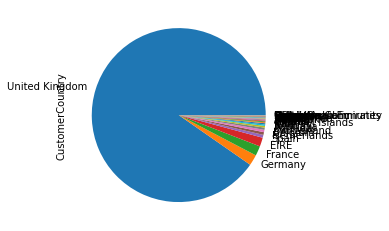

In [8]:
# Customers' nationalities.

countries = df['CustomerCountry'].value_counts()
ax = countries.plot.pie()

All the countries are real, but there are 340 unspecified records' countries.

## Data distribution and quality

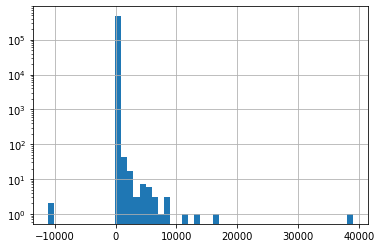

In [9]:
# Sales distribution.

ax = df.Sale.hist(log=True, bins=50)

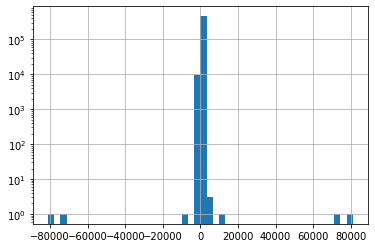

In [10]:
# Qta distribution.

ax = df.Qta.hist(log=True, bins=50)

The majority of purchases have low price.

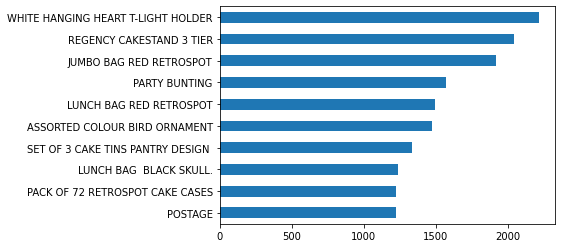

In [11]:
# Top-10 products.

ax = df['ProdDescr'].value_counts().head(10).plot(kind='barh')
ax.invert_yaxis()

The first 9 most sold products are legit ones, but the 10th is "postage", that we assume is related to the shipping, and we're not considering it as a valid product.

After a deeper analysis we've detected some unusual and erroneous ProdID and ProdDescr, and we've put them in two files: blacklist_prod_descr.csv and blacklist_prod_id.csv. An example is a descrition that mocks a colleague, also with typos: "alan hodge cant mamage this section".

Analyzing the data, we also found this relation: (ProdDescr = null) $\Rightarrow$ (CustomerID = null $\land$ Sale = 0).

### CustomerID analysis

Given the high number of null CustomerIDs, we decided to consider them valid, under certain conditions (see next).

# Data preparation

## New features

We want to analyze the customers' behavior on the day of the week.

In [12]:
df['BasketDay'] = df['BasketDate'].dt.day_name()

As said before, the BasketID starting with a 'C' have been considered canceled. We added a new booleand field "Canceled" to keep track of them, then we removed the 'C' from the BasketID, and we reversed the quantity for further simplicity.

In [13]:
canceled = "C"
df['Canceled'] = df['BasketID'].apply(lambda x : x.startswith(canceled))
df['BasketID'] = df['BasketID'].apply(lambda x : x[1:] if x.startswith(canceled) else x)
df['Qta'] = np.where(df['Canceled'], abs(df['Qta']), df['Qta'])

We compute the total price of every row.

In [14]:
df['Total'] = df['Sale'] * df['Qta']

## Data cleaning

Remove the aborted transactions.

In [15]:
df = df[~(df['Sale'] < 0)]
df['BasketID'] = df['BasketID'].astype(int)

Then we remove the rows with bad ProdDescr and ProdID.

In [16]:
# To find bad descriptions.
#df['ProdDescr'].value_counts().to_csv('prodlist.csv')

In [17]:
with open('blacklist_prod_descr.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdDescr'].isin(blacklist)]

In [18]:
# If len < 5 or > 6, probably not a valid product. We made another blacklist.

with open('blacklist_prod_id.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdID'].isin(blacklist)]

We found few zero prices, and in most of the cases, also null ProdDescr. We decided to get rid of them.

In [19]:
df = df[~(df['Sale'] == 0)]

There are still too small values of Sale (less than 1 penny). We remove them.

In [20]:
df = df[~(df['Sale'] < 0.01)]

5.27% of BasketIDs removed.

In [21]:
# Percentage for each country dropped.

countries_after = df['CustomerCountry'].value_counts()
dropped = (1 - countries_after.divide(countries)) * 100
dropped

Australia               0.397141
Austria                 3.491272
Bahrain                 0.000000
Belgium                 4.736588
Brazil                  0.000000
Canada                  0.662252
Channel Islands         0.659631
Cyprus                  0.482315
Czech Republic          6.666667
Denmark                 3.598972
EIRE                    1.495399
European Community      4.918033
Finland                 6.043165
France                  3.800587
Germany                 4.212744
Greece                  2.739726
Hong Kong               2.173913
Iceland                 0.000000
Israel                  0.000000
Italy                   2.490660
Japan                   0.837989
Lebanon                 0.000000
Lithuania               0.000000
Malta                   3.149606
Netherlands             1.897933
Norway                  2.486188
Poland                  1.466276
Portugal                2.943144
RSA                     1.724138
Saudi Arabia            0.000000
Singapore 

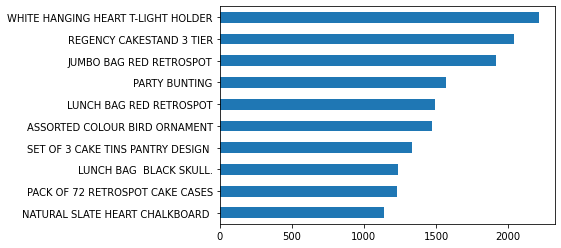

In [22]:
# New top-10 products.

ax = df['ProdDescr'].value_counts().head(10).plot(kind='barh')
ax.invert_yaxis()

In [23]:
df.describe()

,BasketID,Sale,CustomerID,Qta,Total
count,468251.000000,468251.000000,404876.000000,468251.000000,468251.000000
mean,560237.417710,3.108507,15295.253282,12.028444,21.287866
std,13289.254039,4.461019,1710.404209,231.039821,393.345586
min,536365.000000,0.030000,12346.000000,1.000000,0.060000
25%,548497.000000,1.250000,13969.000000,2.000000,4.130000
50%,561087.000000,2.080000,15159.000000,4.000000,10.200000
75%,571931.000000,3.750000,16794.000000,12.000000,17.700000
max,581587.000000,649.500000,18287.000000,80995.000000,168469.600000


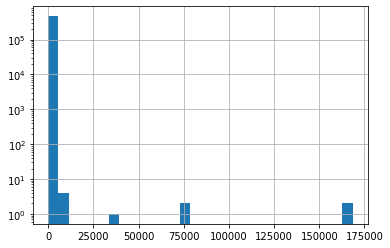

In [24]:
ax = df.Total.hist(log=True, bins=30)
#ax.set_xlim((0, 82000))

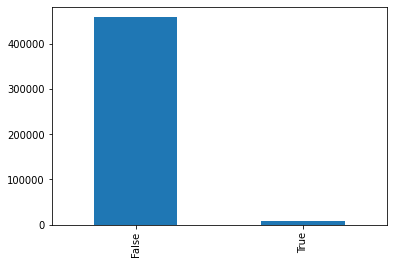

In [25]:
ax = df['Canceled'].value_counts().plot(kind='bar')

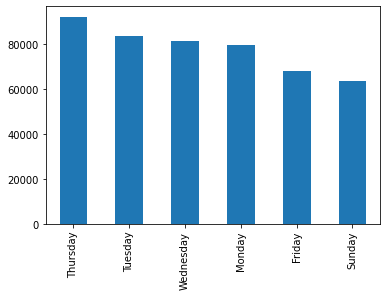

In [26]:
ax = df['BasketDay'].value_counts().plot(kind='bar')

There are no sales on saturday.

In [27]:
not_canceled = df[~(df['Canceled'])]

# Shopping sessions.
#ss_total = not_canceled.groupby(['BasketID']).agg({'Qta': 'mean'})

#ax = ss_total.Qta.hist(bins=100000)
#ax.set_xlim((0, 100))

In [28]:
#ax = ss_total.plot.scatter(x='Qta', y='Total')

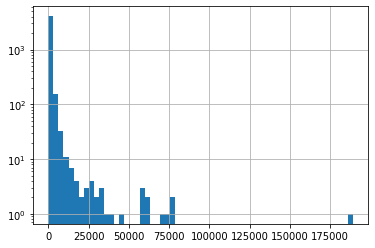

In [29]:
# total number of items purchased by a customer during a period.

start_date = '2010-12-01'
end_date = '2011-12-05'

mask = (not_canceled['BasketDate'] >= start_date) & (not_canceled['BasketDate'] <= end_date)
filtered = not_canceled.loc[mask]
ss_l = filtered.groupby('CustomerID').agg({'Qta': 'sum'})
ax = ss_l.Qta.hist(log=True, bins=60)

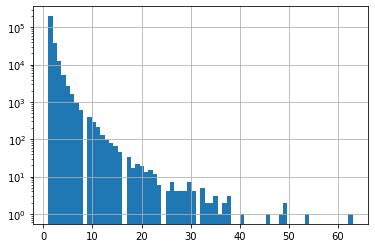

In [30]:
# total number of distinct items purchased by a customer during a period.

start_date = '2010-12-01'
end_date = '2011-12-05'

mask = (not_canceled['BasketDate'] >= start_date) & (not_canceled['BasketDate'] <= end_date)
filtered = not_canceled.loc[mask]
ss_lu = filtered.groupby(['CustomerID', 'ProdID']).agg({'Qta': 'count'})
ax = ss_lu.Qta.hist(log=True, bins=70)

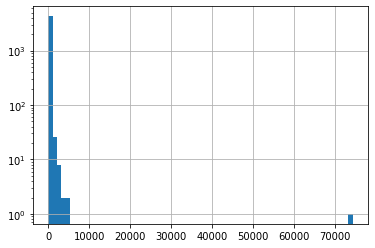

In [31]:
# max number of items purchased by a customer during a shopping session.

start_date = '2010-12-01'
end_date = '2011-12-05'

mask = (not_canceled['BasketDate'] >= start_date) & (not_canceled['BasketDate'] <= end_date)
filtered = not_canceled.loc[mask]
ss_temp = filtered.groupby(['BasketID']).agg({'Qta': 'sum'})
ss_imax = filtered.groupby(['CustomerID']).agg({'Qta': 'max'})
ax = ss_imax.Qta.hist(log=True, bins=70)

In [32]:
# entropy on shopping date for customer predictability.

customer_list = not_canceled['CustomerID'].unique()
entropies = []

for customer in customer_list:
    data = not_canceled[not_canceled['CustomerID'] == customer]
    prob = data['BasketDay'].value_counts()
    entropy = stats.entropy(prob)
    entropies.append(entropy)

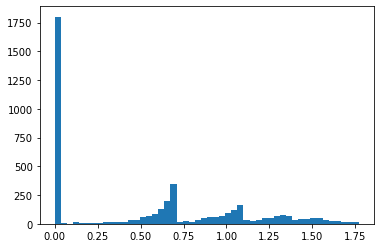

In [33]:
plt.hist(entropies, bins=50)
plt.show()

In [34]:
# How many days since the last purchase?
recency = df.groupby(by='CustomerID', as_index=False)['BasketDate'].max()

last = df['BasketDate'].max() + dt.timedelta(days=1)

recency['Recency'] = recency['BasketDate'].apply(lambda x: (last - x).days)
del recency['BasketDate']
recency.head()

,CustomerID,Recency
0,12346.0,326
1,12347.0,2
2,12348.0,75
3,12349.0,19
4,12350.0,310


In [35]:
# How many times a customer has bought in this market?

frequency = not_canceled.groupby(by=['CustomerID'], as_index=False)['BasketID'].nunique()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1


In [36]:
# How much has a customer spent?

monetary = not_canceled.groupby(by=['CustomerID'], as_index=False)['Total'].sum()
monetary.columns = ['CustomerID', 'Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40


In [37]:
# RFM table.

rfm = recency.merge(frequency.merge(monetary, on='CustomerID'), on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40


In [38]:
# Compute customer ranks on total money spent.

#rank = rfm.copy()
#rank['Rank'] = rank['Monetary'].rank(ascending=0)
#rank.sort_values('Rank', ascending=True).head()

In [39]:
quantiles = rfm.quantile(q=[0.2, 0.4, 0.6, 0.8])
quantiles

,CustomerID,Recency,Frequency,Monetary
0.2,13505.6,11.0,1.0,248.534
0.4,14705.6,31.0,2.0,484.846
0.6,15882.8,70.0,3.0,925.250
0.8,17080.4,176.0,5.0,2043.426


In [40]:
def RScore(x, data, thresh):
    if x <= thresh[data][0.2]:
        return 5
    elif x <= thresh[data][0.4]:
        return 4
    elif x <= thresh[data][0.6]: 
        return 3
    elif x <= thresh[data][0.8]: 
        return 2
    else:
        return 1

def FMScore(x, data, thresh):
    if x <= thresh[data][0.2]:
        return 1
    elif x <= thresh[data][0.4]:
        return 2
    elif x <= thresh[data][0.6]: 
        return 3
    elif x <= thresh[data][0.8]: 
        return 4
    else:
        return 5

In [41]:
rfm_scored = rfm.copy()
rfm_scored['RScore'] = rfm_scored['Recency'].apply(RScore, args=('Recency', quantiles))
rfm_scored['FScore'] = rfm_scored['Frequency'].apply(FMScore, args=('Frequency', quantiles))
rfm_scored['MScore'] = rfm_scored['Monetary'].apply(FMScore, args=('Monetary', quantiles))
rfm_scored['RFMScore'] = rfm_scored['RScore'] + rfm_scored['FScore'] + rfm_scored['MScore']
rfm_scored

,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore
0,12346.0,326,1,77183.60,1,1,5,7
1,12347.0,2,7,4310.00,5,5,5,15
2,12348.0,75,4,1437.24,2,4,4,10
3,12349.0,19,1,1457.55,4,1,4,9
4,12350.0,310,1,294.40,1,1,2,4
...,...,...,...,...,...,...,...,...
4329,18280.0,278,1,180.60,1,1,1,3
4330,18281.0,181,1,80.82,1,1,1,3
4331,18282.0,8,2,178.05,5,2,1,8
4332,18283.0,4,16,2088.93,5,5,5,15


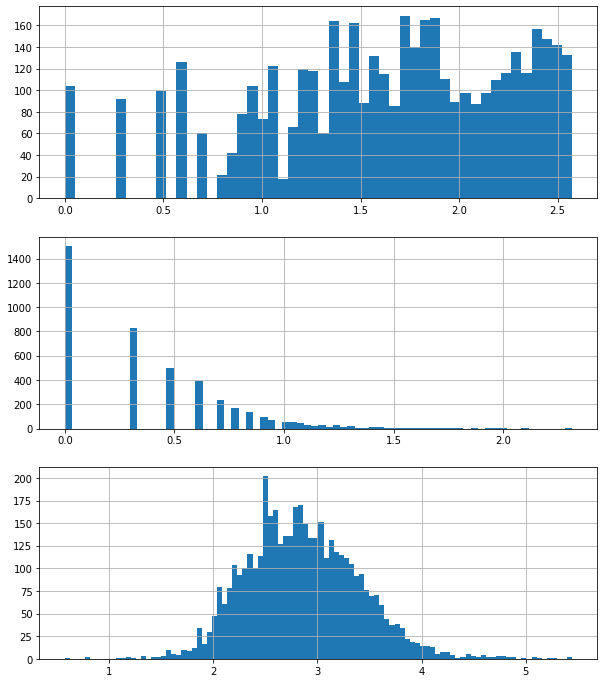

In [42]:
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log10, axis=1).round(3)

# plot the distribution of RFM values
f, ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); rfm_log.Recency.hist(bins=50, label='Recency')
plt.subplot(3, 1, 2); rfm_log.Frequency.hist(bins=70, label='Frequency')
plt.subplot(3, 1, 3); rfm_log.Monetary.hist(bins=100, label='Monetary')
plt.show()

In [43]:
#ax = rfm.boxplot(column='Frequency')
#rfm.describe()

# Clustering

In [44]:
rfm_k = rfm_log[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm_k.values)
scaled

array([[ 1.41398639, -1.04381577,  3.71988991],
       [-2.07450174,  1.11922691,  1.42349612],
       [ 0.40781305,  0.49719215,  0.55181874],
       ...,
       [-1.12510308, -0.27331181, -1.10912955],
       [-1.59980241,  2.03820008,  0.84848205],
       [ 0.02616109,  0.17721543,  0.74593177]])

In [45]:
sse = []
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(scaled)
    sse.append(kmeans.inertia_)

In [46]:
sse

[6379.2600301546, 4825.850364975424, 3931.727543535094, 3369.6062383419962]

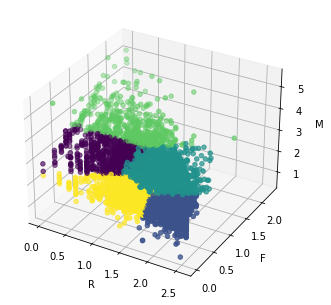

In [47]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Recency'], rfm_log['Frequency'], rfm_log['Monetary'], c=kmeans.labels_)
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
plt.show()